# Energy transition: from fossil fuels to solar and wind

This notebook presents a simplified way to make an estimate of how long it might take to phase out fossil fuels. We consider a logistic growth model applied to uptake of solar and wind energy as a replacement for fossil fuels.

We make the following assumptions...

* We can predict energy demand this century.

* Nuclear, hydro, biofuels, and other renewables ('other' zero-carbon) don't change much.

* Solar and wind energy have logistic growth with:   
(1) growth factors estimated from recent trends (last 25 years); and  
(2) carrying capacity in any particular year equal to existing capacity + remaining fossil fuel capacity.


## Primary energy supply

Most energy statistics are reported as 'primary energy'. Primary energy is defined as energy in nature that has not yet been subjected to any human engineered conversion process. It is raw energy contained in fuels (e.g. coal). Primary energy can be non-renewable or renewable. Most energy statistics are 'primary energy'. So, for example, the raw thermal value of coal supplied to a power station is measured, rather than the electricity produced (only 30-40% of the primary energy is delivered as electricity), or the potential thermal energy of petrol in a car is measured rather than useable work produced by the engine (again only 30-40% of the input energy). For fossil fuels and firewood (most primary energy used by humans in last century), this is straightforward to understand, but it starts to become more difficult with nuclear or renewables. We will come back to this point.

Let's start by looking at historical data...


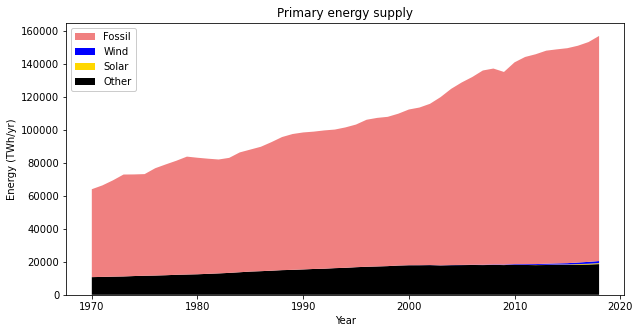

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Force use of TrueType fonts in pdfs for later editing
from matplotlib import rc
rc("pdf", fonttype=42)

filename = '../data/energy-consumption/global-primary-energy.csv'
energyYear = np.genfromtxt(filename,delimiter=',',skip_header=1,usecols=(2,))
energy = np.genfromtxt(filename,delimiter=',',skip_header=1,usecols=range(3,12))
energyTotal = np.sum(energy, axis=1)

energyType = ['Coal','Solar','Oil','Gas','Traditional biofuels',
              'Other renewables','Hydro','Nuclear','Wind']
# See below for how to 'slice' data into columns
eSolar  = energy[:,1]
eWind   = energy[:,8]
eFossil = energy[:,0] + energy[:,2] + energy[:,3]
eOther  = energy[:,4] + energy[:,5] + energy[:,6] + energy[:,7] 

plt.figure(figsize=[10,5])

sel = (energyYear >= 1970) & (energyYear <= 2018)
eValues = (eOther[sel],eSolar[sel],eWind[sel],eFossil[sel])
eLabels = ('Other','Solar','Wind','Fossil')
eColors = ('black','gold','blue','lightcoral')
plt.stackplot(energyYear[sel],eValues,labels=eLabels,colors=eColors)

plt.legend(reversed(plt.legend().legendHandles), reversed(eLabels),
           loc='upper left', framealpha=1.0 )
plt.title('Primary energy supply')
plt.xlabel('Year')
plt.ylabel('Energy (TWh/yr)')
plt.savefig("../figs/primaryEnergy.pdf")
plt.show()

Fossil fuels have been the mainstay of the world's energy supply for the last 50 years.  
It is striking how small the historical contribution from solar and wind is.  
The 'other' (nuclear, hydro, etc.) types of energy haven't changed much.  


## Final energy consumption

To start with we need to address the difference between **primary energy supply** and **final energy consumption**. This really matters for solar and wind, because the primary solar or wind energy is rarely measured, so we are comparing apples with oranges. The electricity sector consumes ~60% of primary energy derived from fossil fuels during conversion to electricity, and there are additional losses during transmission from a small number of central sources. In contrast, solar PV electricity output is measured directly and used locally. A gasoline car loses 65-75% of available primary energy, whereas an electric car loses only 15-20%.  

To acknowledge this issue, we multiply the fossil fuel primary energy data by a factor of 0.5 to convert to final energy consumption (some fossil fuels are used for heat). It is an over-simplification, but we are just trying to get an approximate model.


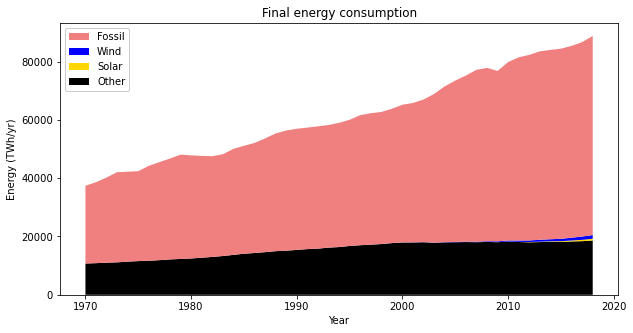

In [2]:
plt.figure(figsize=[10,5])

eValues = (eOther[sel],eSolar[sel],eWind[sel],0.5*eFossil[sel])

plt.stackplot(energyYear[sel],eValues,labels=eLabels,colors=eColors)

plt.legend(reversed(plt.legend().legendHandles), reversed(eLabels),
           loc='upper left', framealpha=1.0 )
plt.title('Final energy consumption')
plt.xlabel('Year')
plt.ylabel('Energy (TWh/yr)')
plt.savefig("../figs/finalEnergy.pdf")
plt.show()

## Energy efficiency

Humans use energy to generate wealth. Wealth is a key way that we measure our well-being. How much energy has it taken to generate wealth in the past, and how much will be needed in future?

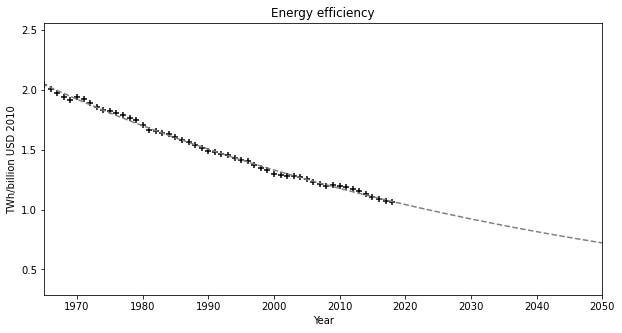

In [3]:
# GDP per capita (wealth) data
filename = '../data/economy/gdp-per-capita-world-usd2010.csv'
gdpYear = np.genfromtxt(filename,delimiter=',',skip_header=1,usecols=(0,))
gdpPerCapita = np.genfromtxt(filename,delimiter=',',skip_header=1,usecols=(1,))

#-------------------------------------------------------
# world population; convert N from thousands to units of billions
filename = '../data/world-population/UN2019-population-projection-world-Medium.csv'
unPopulationModel = np.genfromtxt(filename, delimiter=',', names=True)
t = unPopulationModel['Time']
N = unPopulationModel['PopTotal'] / 1e6

#-------------------------------------------------------
# Final energy consumption
eFinal = eSolar + eWind + eOther + 0.5 * eFossil

#-------------------------------------------------------
# Select years with consistent data
yearMin = 1965
yearMax = 2018
selEnergy = (energyYear >= yearMin) & (energyYear <= yearMax)
selGDP = (gdpYear >= yearMin) & (gdpYear <= yearMax)
selN = (t >= yearMin) & (t <= yearMax)

# TWh needed to generate a billion USD of gdp
energyEfficiency = eFinal[selEnergy] / (gdpPerCapita[selGDP] * N[selN])

# Fit an exponential decay model to the data
modelParameters = np.polyfit(energyYear[selEnergy],np.log(energyEfficiency),1)
modelFuncLogEnergyPerGDP = np.poly1d(modelParameters)
modelEnergyPerGDP = np.exp(modelFuncLogEnergyPerGDP(t))

# Plot
plt.figure(figsize=[10,5])
plt.title('Energy efficiency')
plt.scatter(t[selN],energyEfficiency,color='black',marker='+')
plt.plot(t,modelEnergyPerGDP,linestyle='--',color='grey')
plt.xlim(yearMin,2050)
plt.xlabel('Year')
plt.ylabel('TWh/billion USD 2010')
plt.savefig("../figs/energyEfficiency.pdf")
plt.show()

An exponential model of steadily improving energy efficiency fits the data well. We need less energy each year to generate the same amount of GDP (wealth).

## Future energy demand: the gap to fill  

We construct a model for final energy demand assuming it depends on:
* Changes in energy efficiency  
* Global annual wealth (GDP)

We previously anlayzed GDP per capita data and showed it had a linear trend, so we project this trend forward and multiply by the UN population prediction to find future global annual GDP. 

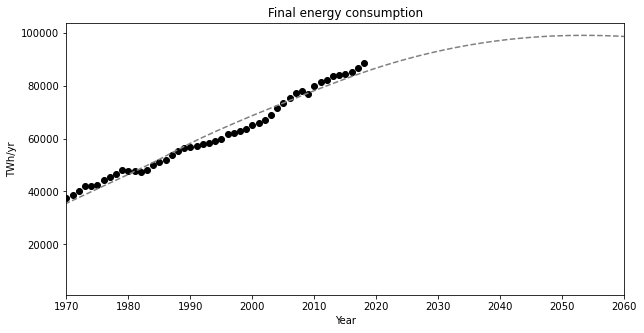

In [4]:
# Find linear trend in GDP/capita and extrapolate to population prediction
modelParameters = np.polyfit(gdpYear,gdpPerCapita,1)
gdpPerCapitaFunction = np.poly1d(modelParameters)

finalEnergyPrediction = gdpPerCapitaFunction(t) * N * modelEnergyPerGDP

plt.figure(figsize=[10,5])
plt.title('Final energy consumption')
plt.scatter(energyYear,eFinal,color='black',marker='o')
plt.plot(t,finalEnergyPrediction,linestyle='--',color='grey')
plt.xlim(1970,2060)
plt.xlabel('Year')
plt.ylabel('TWh/yr')
plt.savefig("../figs/energyPrediction.pdf")
plt.show()

Demand for energy is forecast to plateau by the middle of the century, as population growth slows and efficiency gains improve.

##  Exponential growth of solar and wind energy
We can approximate the initial growth of solar and wind energy $E$ with an exponential model.

\begin{equation}  \frac{dE}{dt} = k E  \end{equation} 

\begin{equation}  \frac{d(\ln E)}{dt} = k  \end{equation} 

We find the growth factor, $k$ by looking at the gradient of $\ln E$ plotted against $t$.

In [5]:
select = (energyYear >= 1995) & (energyYear < 2020)

modelParametersSolar = np.polyfit(energyYear[select],np.log(eSolar[select]),1)
modelParametersWind = np.polyfit(energyYear[select],np.log(eWind[select]),1)

kSolar = modelParametersSolar[0]
kWind = modelParametersWind[0]

print('Annual growth factor solar = {:.1f}%'.format(kSolar*100.))
print('Annual growth factor wind = {:.1f}%'.format(kWind*100.))

Annual growth factor solar = 33.1%
Annual growth factor wind = 22.9%


## Logistic growth  of solar and wind 
The current proportion of energy provided by wind and solar is very small and growth is exponential, but this can't carry on indefinitely. We assume growth of solar and wind continues according to a logistic model. 

\begin{equation}  dE = k E \left(1 - \frac{E}{P} \right) dt \end{equation} 

where $dE$ is the incremental change in $E$ over time $dt$ (one year). $E$ is the energy produced at time $t$ by either solar or wind, and $P$ is the maximum capacity for that energy type, which is the current value of $E + E_{fossil}$. The remaining fossil fuel energy use is a gap needing to be filled!

We do not have to solve this differential equation. We can simply add up all the differences - a finite difference method. We start at the end of the historical data, then append values to each array until we have filled in all the model values.


In [6]:
iStart = np.where(t == energyYear[-1])[0][0] + 1

for i in range(iStart, len(t)) :
    energyYear = np.append(energyYear,t[i])
    # append the same value of eOther, i.e. the last value in the array
    eOther = np.append(eOther,eOther[-1])
    # Solar
    P = eSolar[-1] + eFossil[-1]
    dE = kSolar * eSolar[-1] * (1 - eSolar[-1] / P)
    eSolar = np.append(eSolar, eSolar[-1] + dE)
    # Wind
    P = eWind[-1] + eFossil[-1]
    dE  = kWind * eWind[-1] * (1 - eWind[-1] / P)
    eWind  = np.append(eWind ,  eWind[-1] + dE)
    # Fossil fuels is what is left
    eFossil = np.append(eFossil,
                     finalEnergyPrediction[i] - eOther[-1] - eSolar[-1] - eWind[-1])

np.save('../store/eYear.npy',energyYear)
np.save('../store/eFossil.npy',eFossil)
np.save('../store/eSolar.npy',eSolar)
np.save('../store/eWind.npy',eWind)
np.save('../store/eOther.npy',eOther)

## Energy transition


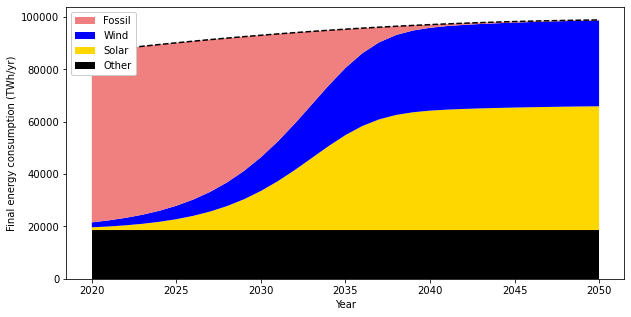

In [7]:
plt.figure(figsize=[10,5])

sel = (energyYear >= 2020) & (energyYear <= 2050)
eValues = (eOther[sel],eSolar[sel],eWind[sel],eFossil[sel])
eLabels = ('Other','Solar','Wind','Fossil')
eColors = ('black','gold','blue','lightcoral')
plt.stackplot(energyYear[sel],eValues,labels=eLabels,colors=eColors)

plt.legend(reversed(plt.legend().legendHandles), reversed(eLabels),
           loc='upper left', framealpha=1.0 )

sel2 = (t >= 2020) & (t <= 2050)
plt.plot(t[sel2],finalEnergyPrediction[sel2],linestyle='--')

plt.xlabel('Year')
plt.ylabel('Final energy consumption (TWh/yr)')
plt.savefig('../figs/energyTransition.pdf')

## Your tasks  

How does this result compare to published 'scenarios' for energy transition?  Aim to extract several different published scenarios and add/label on the same plot. Where do the scenarios differ?
Discuss this rather amazing (optimistic) result. What were our assumptions? Are any in significant doubt?

Perhaps one of the biggest uncertainties is whether the growth factors for solar and wind are sustainable. Plot graphs showing the data used to find growth factors and the regression lines through those data. Use a log scale `plt.yscale('log')`. Are the gradients of the data reasonably constant? We find a growth factor $k$ by determining the gradient of each line (the first model parameter). Does the choice of years used for the fit make a great deal of difference? 